In [1]:
!pip install eco2ai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 3.9 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/kaggle/input/attentionsnn/pytorch/attentionsnn/2')

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from simple_utils import (
    save_checkpoint,
    load_checkpoint,
    get_loaders,
    check_accuracy,
    save_predictions_as_imgs,
    summarize_eco2ai_log,
    )

import resnet_2

from datetime import datetime
import glob
import random

from eco2ai import Tracker
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet_2.resnet34().to(device)

In [5]:
summary(model, input_size=(1, 256, 256), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Snn_Conv2d-1      [32, 2, 64, 128, 128]           3,136
      BatchNorm3d1-2      [32, 64, 1, 128, 128]             128
     batch_norm_2d-3      [32, 2, 64, 128, 128]               0
        mem_update-4      [32, 2, 64, 128, 128]               0
        Snn_Conv2d-5        [32, 2, 64, 64, 64]          36,864
      BatchNorm3d1-6        [32, 64, 1, 64, 64]             128
     batch_norm_2d-7        [32, 2, 64, 64, 64]               0
        mem_update-8        [32, 2, 64, 64, 64]               0
        Snn_Conv2d-9        [32, 2, 64, 64, 64]          36,864
     BatchNorm3d2-10        [32, 64, 1, 64, 64]             128
   batch_norm_2d1-11        [32, 2, 64, 64, 64]               0
AdaptiveAvgPool3d-12          [32, 64, 1, 1, 1]               0
           Conv3d-13           [32, 8, 1, 1, 1]             512
             ReLU-14           [32, 8, 

In [6]:
IMG_DIR      =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/images"
MASK_DIR     =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/masks"
VAL_IMG_DIR  =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/val_images"
VAL_MASK_DIR =  "/kaggle/input/braindataset/Modified_3_Brain_Tumor_Segmentation/val_masks"

In [7]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
Learning_rate = 1e-3
Batch_size  = 32
num_epochs  = 60
num_workers = 4
IMAGE_HEIGHT = 256 
IMAGE_WIDTH  = 256  
PIN_MEMORY = True
LOAD_MODEL = False
CHECKPOINT_NAME = None

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-8):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

In [9]:
def train_fn(loader, model, optimizer, loss_fn, dice_loss_fn, scaler):

    tracker = Tracker(
        project_name="attentionSNN_Training_Project",
        experiment_description="Training CSA Spiking Upsampling Layer Model",
        file_name="attentionSNN_eco2ai_logs.csv",
        alpha_2_code="EG",  
    )
    tracker.start()

    loop = tqdm(loader)
    running_loss=0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=Device)
        targets = targets.float().unsqueeze(1).to(device=Device) 

        with torch.amp.autocast(device_type=Device):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            # dice_loss = dice_loss_fn(predictions, targets)
            # loss += dice_loss  # Combined hybrid loss
        
        running_loss+=loss.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss=loss.item())
    
    tracker.stop()

    nasar = model.calculate_nasar()
    
    return running_loss/len(loader), nasar 

In [15]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0],
                std=[1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    model = resnet_2.resnet34().to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    dice_loss_fn = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=Learning_rate)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)  
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    train_loader, val_loader = get_loaders(
        IMG_DIR,
        MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        Batch_size,
        train_transform,
        val_transform,
        num_workers,
        PIN_MEMORY,
    )

    train_losses=[]
    val_dice_scores=[]
    val_accs=[]
    train_nasar=[]

    if LOAD_MODEL:
        load_checkpoint(model=model, optimizer=optimizer, checkpoint_name=CHECKPOINT_NAME)
        val_acc_loaded, val_dice_loaded = check_accuracy(val_loader, model, device=Device)

    scaler = torch.amp.GradScaler()

    for epoch in range(num_epochs):
        train_loss, nasar = train_fn(train_loader, model, optimizer, loss_fn, dice_loss_fn, scaler)

        val_acc, val_dice = check_accuracy(val_loader, model, device=Device)

        train_losses.append(train_loss)
        val_accs.append(val_acc.cpu().item())
        val_dice_scores.append(val_dice.cpu().item())
        train_nasar.append(nasar)

        scheduler.step(val_dice)
        print(f"Epoch {epoch}: LR = {optimizer.param_groups[0]['lr']}")

        checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        }

        checkpoint_filename = save_checkpoint(checkpoint, is_best=len(val_dice_scores) == 1 or val_dice_scores[-1] > max(val_dice_scores[:-1]))

        if epoch != num_epochs - 1:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                train_nasar=train_nasar,
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=False,
            )
        else:
            save_predictions_as_imgs(
                val_loader, 
                model, 
                checkpoint_filename=checkpoint_filename, 
                train_losses=train_losses,
                val_accs=val_accs,
                val_dice_scores=val_dice_scores,
                train_nasar=train_nasar, 
                folder="Att_Res_SNN_saved_images/", 
                device=Device, 
                show_last_epoch=True,
            )

100%|██████████| 82/82 [00:32<00:00,  2.49it/s, loss=0.665]


NASAR: 0.15274032964939024
Got 25638184/29360128 with acc  87.32
Dice score: 0.18912288546562195
Epoch 0: LR = 0.0009991177326210683
✅ Checkpoint saved: Att_Res_SNN_checkpoint_1_2025-05-19_09-04-31.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.60it/s, loss=0.622]


NASAR: 0.14654191800249303
Got 25742709/29360128 with acc  87.68
Dice score: 0.19224421679973602
Epoch 1: LR = 0.000999088378850232
✅ Checkpoint saved: Att_Res_SNN_checkpoint_2_2025-05-19_09-05-23.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.58] 


NASAR: 0.14529203709548083
Got 26980543/29360128 with acc  91.90
Dice score: 0.24563758075237274
Epoch 2: LR = 0.0009985119626270734
✅ Checkpoint saved: Att_Res_SNN_checkpoint_3_2025-05-19_09-06-15.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.548]


NASAR: 0.15138382950449378
Got 28146375/29360128 with acc  95.87
Dice score: 0.3037338852882385
Epoch 3: LR = 0.0009977254432894695
✅ Checkpoint saved: Att_Res_SNN_checkpoint_4_2025-05-19_09-07-07.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.515]


NASAR: 0.14721667281980436
Got 28371251/29360128 with acc  96.63
Dice score: 0.3438279330730438
Epoch 4: LR = 0.0009970859315506678
✅ Checkpoint saved: Att_Res_SNN_checkpoint_5_2025-05-19_09-07-59.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.488]


NASAR: 0.1499979903058308
Got 28169297/29360128 with acc  95.94
Dice score: 0.35613954067230225
Epoch 5: LR = 0.0009968737260486846
✅ Checkpoint saved: Att_Res_SNN_checkpoint_6_2025-05-19_09-08-51.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.56it/s, loss=0.466]


NASAR: 0.15301142126564088
Got 27650565/29360128 with acc  94.18
Dice score: 0.31693679094314575
Epoch 6: LR = 0.0009975235690318036
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.441]


NASAR: 0.15776248714788174
Got 28223645/29360128 with acc  96.13
Dice score: 0.3617396056652069
Epoch 7: LR = 0.0009967747423924231
✅ Checkpoint saved: Att_Res_SNN_checkpoint_7_2025-05-19_09-10-34.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.419]


NASAR: 0.14769775886845782
Got 28446324/29360128 with acc  96.89
Dice score: 0.38122785091400146
Epoch 8: LR = 0.0009964182952693036
✅ Checkpoint saved: Att_Res_SNN_checkpoint_8_2025-05-19_09-11-26.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.396]


NASAR: 0.15105512045263275
Got 28800724/29360128 with acc  98.09
Dice score: 0.3665236532688141
Epoch 9: LR = 0.0009966889639199245
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.378]


NASAR: 0.14578712277296113
Got 28731858/29360128 with acc  97.86
Dice score: 0.3901970684528351
Epoch 10: LR = 0.0009962479903768016
✅ Checkpoint saved: Att_Res_SNN_checkpoint_9_2025-05-19_09-13-10.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.356]


NASAR: 0.15422196427011878
Got 28631556/29360128 with acc  97.52
Dice score: 0.3980735242366791
Epoch 11: LR = 0.0009960951868369934
✅ Checkpoint saved: Att_Res_SNN_checkpoint_10_2025-05-19_09-14-01.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.341]


NASAR: 0.14873239780829206
Got 28853172/29360128 with acc  98.27
Dice score: 0.3053423762321472
Epoch 12: LR = 0.0009977013072532822
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.321]


NASAR: 0.15503925230444932
Got 28771828/29360128 with acc  98.00
Dice score: 0.4151415228843689
Epoch 13: LR = 0.0009957536441506007
✅ Checkpoint saved: Att_Res_SNN_checkpoint_11_2025-05-19_09-15-45.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.308]


NASAR: 0.14596089929099976
Got 28822437/29360128 with acc  98.17
Dice score: 0.38574713468551636
Epoch 14: LR = 0.0009963329770460744
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.289]


NASAR: 0.14984293371681276
Got 28870163/29360128 with acc  98.33
Dice score: 0.3113822638988495
Epoch 15: LR = 0.0009976095416816045
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.283]


NASAR: 0.15275866500730437
Got 28782784/29360128 with acc  98.03
Dice score: 0.4044573903083801
Epoch 16: LR = 0.000995969110491213
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.27] 


NASAR: 0.15298414152812181
Got 28860020/29360128 with acc  98.30
Dice score: 0.3541244864463806
Epoch 17: LR = 0.0009969089662624252
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.255]


NASAR: 0.15808044681704142
Got 28868694/29360128 with acc  98.33
Dice score: 0.3333517611026764
Epoch 18: LR = 0.0009972606445711506
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.244]


NASAR: 0.15724888002969384
Got 28855131/29360128 with acc  98.28
Dice score: 0.4009522795677185
Epoch 19: LR = 0.0009960385800411571
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.24] 


NASAR: 0.15570709104460428
Got 28824974/29360128 with acc  98.18
Dice score: 0.4120235741138458
Epoch 20: LR = 0.0009958171006610914
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.229]


NASAR: 0.14886881510416666
Got 28660077/29360128 with acc  97.62
Dice score: 0.4330677390098572
Epoch 21: LR = 0.0009953795799405862
✅ Checkpoint saved: Att_Res_SNN_checkpoint_12_2025-05-19_09-22-36.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.216]


NASAR: 0.14490138728444169
Got 28810005/29360128 with acc  98.13
Dice score: 0.42471590638160706
Epoch 22: LR = 0.0009955558121346108
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.212]


NASAR: 0.15059067640847307
Got 28788350/29360128 with acc  98.05
Dice score: 0.43898019194602966
Epoch 23: LR = 0.000995252760144593
✅ Checkpoint saved: Att_Res_SNN_checkpoint_13_2025-05-19_09-24-19.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.2]  


NASAR: 0.1444282345655488
Got 28623759/29360128 with acc  97.49
Dice score: 0.4467470645904541
Epoch 24: LR = 0.000995083566562077
✅ Checkpoint saved: Att_Res_SNN_checkpoint_14_2025-05-19_09-25-10.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.189]


NASAR: 0.15649962386464686
Got 28847903/29360128 with acc  98.26
Dice score: 0.3831901252269745
Epoch 25: LR = 0.0009963813730723607
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.182]


NASAR: 0.15802648900970212
Got 28803416/29360128 with acc  98.10
Dice score: 0.46107104420661926
Epoch 26: LR = 0.000994763802531649
✅ Checkpoint saved: Att_Res_SNN_checkpoint_15_2025-05-19_09-26-54.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.175]


NASAR: 0.16640559871022295
Got 28852471/29360128 with acc  98.27
Dice score: 0.40392377972602844
Epoch 27: LR = 0.0009959797243278203
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.169]


NASAR: 0.15885017829212716
Got 28852822/29360128 with acc  98.27
Dice score: 0.40919846296310425
Epoch 28: LR = 0.0009958741863743798
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.162]


NASAR: 0.16181573014918382
Got 28877928/29360128 with acc  98.36
Dice score: 0.3636391758918762
Epoch 29: LR = 0.0009967408168821985
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.164]


NASAR: 0.157959920991727
Got 28880302/29360128 with acc  98.37
Dice score: 0.38394948840141296
Epoch 30: LR = 0.0009963670343449951
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.161]


NASAR: 0.15203238386448806
Got 28854407/29360128 with acc  98.28
Dice score: 0.40116822719573975
Epoch 31: LR = 0.0009960343172151303
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.154]


NASAR: 0.15336883048701092
Got 28875558/29360128 with acc  98.35
Dice score: 0.3643876612186432
Epoch 32: LR = 0.000996727401057084
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.147]


NASAR: 0.163798175594671
Got 28812045/29360128 with acc  98.13
Dice score: 0.4349319040775299
Epoch 33: LR = 0.000995339778591728
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.137]


NASAR: 0.17435081295850802
Got 28857550/29360128 with acc  98.29
Dice score: 0.3996550440788269
Epoch 34: LR = 0.0009960641389048497
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.13] 


NASAR: 0.17302734250944804
Got 28870789/29360128 with acc  98.33
Dice score: 0.3263506293296814
Epoch 35: LR = 0.000997374401691421
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.134]


NASAR: 0.17330397319018356
Got 28837302/29360128 with acc  98.22
Dice score: 0.43209248781204224
Epoch 36: LR = 0.000995400334483687
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.12] 


NASAR: 0.17642522672327554
Got 28872108/29360128 with acc  98.34
Dice score: 0.36047258973121643
Epoch 37: LR = 0.0009967972717743457
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.124]


NASAR: 0.1794972799657806
Got 28857400/29360128 with acc  98.29
Dice score: 0.43087518215179443
Epoch 38: LR = 0.0009954261748136113
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.114]


NASAR: 0.17645110463708397
Got 28803471/29360128 with acc  98.10
Dice score: 0.452840656042099
Epoch 39: LR = 0.0009949487596070707
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.116]


NASAR: 0.17505693513203444
Got 28871990/29360128 with acc  98.34
Dice score: 0.4694412350654602
Epoch 40: LR = 0.0009945723105985104
✅ Checkpoint saved: Att_Res_SNN_checkpoint_16_2025-05-19_09-38-54.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.109]


NASAR: 0.17539918480849848
Got 28846444/29360128 with acc  98.25
Dice score: 0.4406770169734955
Epoch 41: LR = 0.0009952160481392673
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.113]


NASAR: 0.17912044990353468
Got 28875466/29360128 with acc  98.35
Dice score: 0.41791388392448425
Epoch 42: LR = 0.0009956968206154878
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.56it/s, loss=0.106]


NASAR: 0.18545979445542746
Got 28886523/29360128 with acc  98.39
Dice score: 0.45370975136756897
Epoch 43: LR = 0.0009949293851383302
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.101] 


NASAR: 0.17145471960548464
Got 28843750/29360128 with acc  98.24
Dice score: 0.4145909547805786
Epoch 44: LR = 0.0009957648834129705
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.096] 


NASAR: 0.18623360114368967
Got 28861669/29360128 with acc  98.30
Dice score: 0.47609075903892517
Epoch 45: LR = 0.000994417746570141
✅ Checkpoint saved: Att_Res_SNN_checkpoint_17_2025-05-19_09-43-11.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0996]


NASAR: 0.18708906716447535
Got 28885271/29360128 with acc  98.38
Dice score: 0.4211975336074829
Epoch 46: LR = 0.000995629031581626
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0943]


NASAR: 0.18574442669628113
Got 28890393/29360128 with acc  98.40
Dice score: 0.4107089936733246
Epoch 47: LR = 0.0009958437124451996
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0971]


NASAR: 0.18599342408219005
Got 28847827/29360128 with acc  98.26
Dice score: 0.46192267537117004
Epoch 48: LR = 0.00099474447521283
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0844]


NASAR: 0.18712216509066945
Got 28819792/29360128 with acc  98.16
Dice score: 0.45591434836387634
Epoch 49: LR = 0.000994880073435403
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0931]


NASAR: 0.18234750391021975
Got 28906890/29360128 with acc  98.46
Dice score: 0.39694446325302124
Epoch 50: LR = 0.00099611727697179
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0823]


NASAR: 0.19482403266720655
Got 28862185/29360128 with acc  98.30
Dice score: 0.3536152243614197
Epoch 51: LR = 0.0009969178409152035
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0802]


NASAR: 0.19619368266283982
Got 28865753/29360128 with acc  98.32
Dice score: 0.42237719893455505
Epoch 52: LR = 0.0009956045491152936
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0782]


NASAR: 0.19807150615909236
Got 28891984/29360128 with acc  98.41
Dice score: 0.43353062868118286
Epoch 53: LR = 0.0009953697128042866
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0829]


NASAR: 0.20268995083444485
Got 28889417/29360128 with acc  98.40
Dice score: 0.38266703486442566
Epoch 54: LR = 0.0009963912337437705
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0783]


NASAR: 0.1967757310324568
Got 28861872/29360128 with acc  98.30
Dice score: 0.4449138939380646
Epoch 55: LR = 0.0009951237656224679
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0799]


NASAR: 0.20414743190858423
Got 28815988/29360128 with acc  98.15
Dice score: 0.4916295111179352
Epoch 56: LR = 0.0009940481463914354
✅ Checkpoint saved: Att_Res_SNN_checkpoint_18_2025-05-19_09-52-36.pth.tar


100%|██████████| 82/82 [00:31<00:00,  2.57it/s, loss=0.0747]


NASAR: 0.1880648109001842
Got 28891329/29360128 with acc  98.40
Dice score: 0.37270602583885193
Epoch 57: LR = 0.0009965764523140064
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0737]


NASAR: 0.2044061676273501
Got 28898283/29360128 with acc  98.43
Dice score: 0.4682237207889557
Epoch 58: LR = 0.0009946003775516902
 Checkpoint not saved as best model.


100%|██████████| 82/82 [00:31<00:00,  2.58it/s, loss=0.0708]


NASAR: 0.2011613117000921
Got 28889804/29360128 with acc  98.40
Dice score: 0.4100579023361206
Epoch 59: LR = 0.0009958568607586597
 Checkpoint not saved as best model.


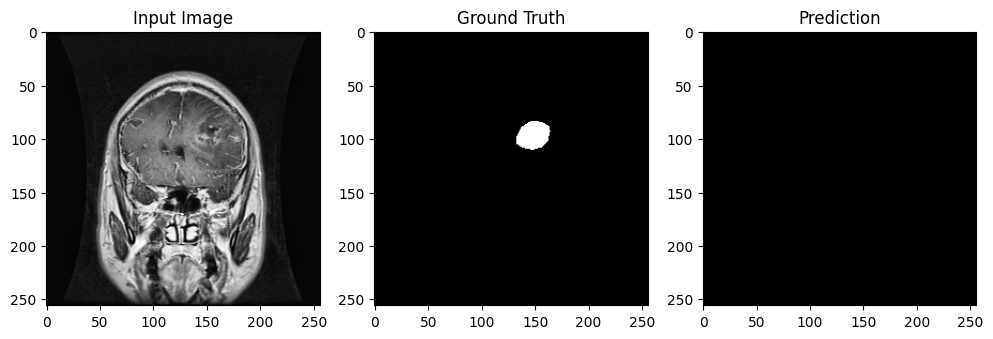

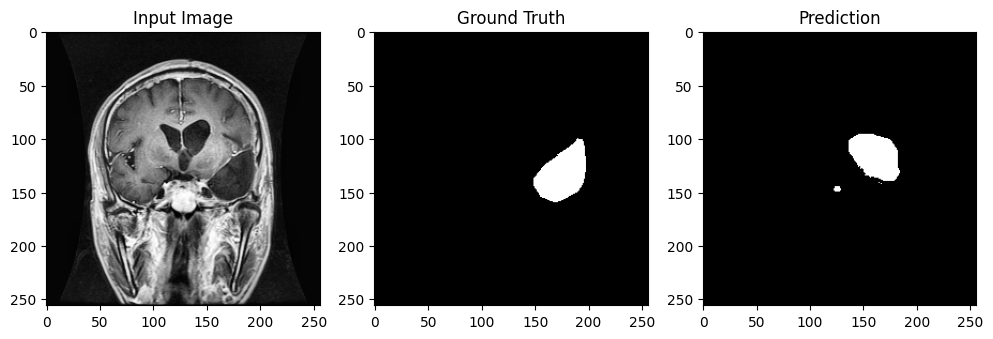

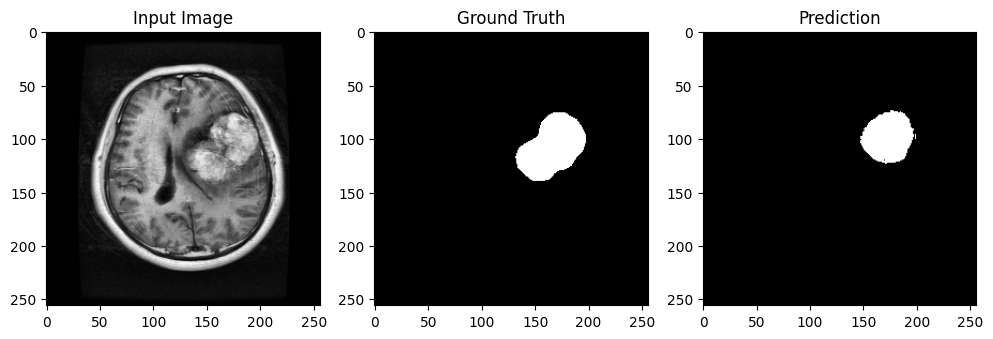

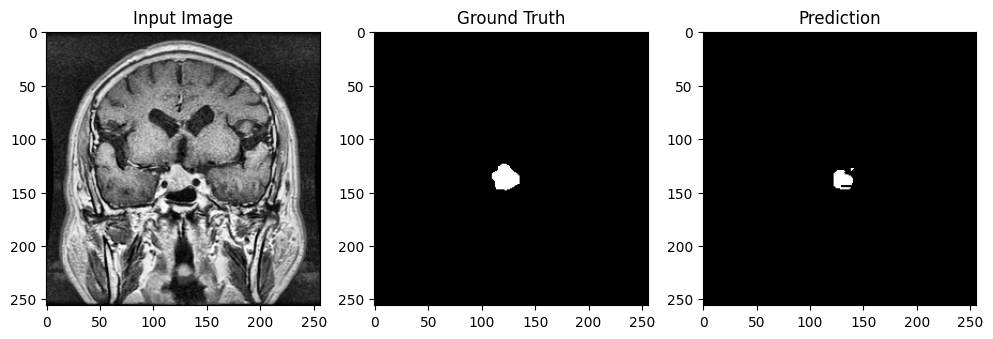

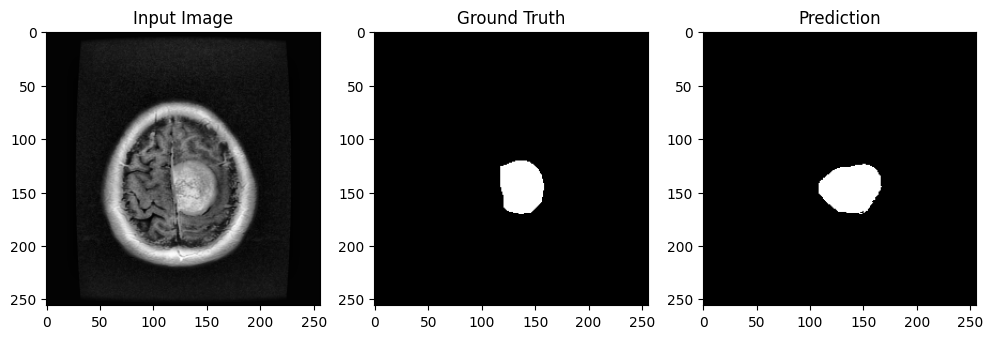

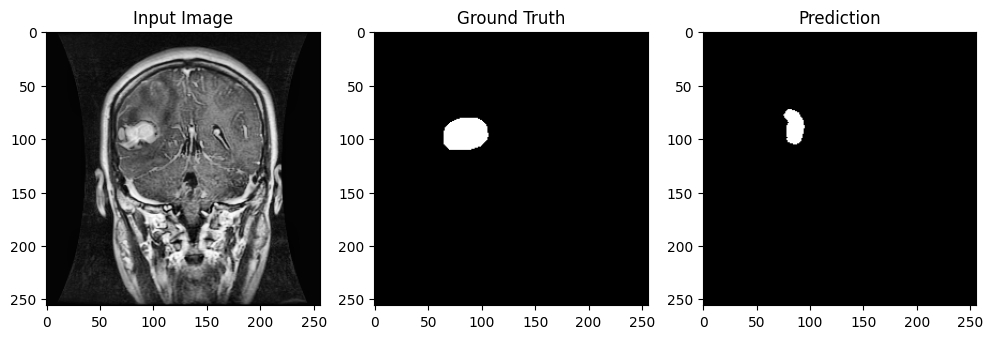

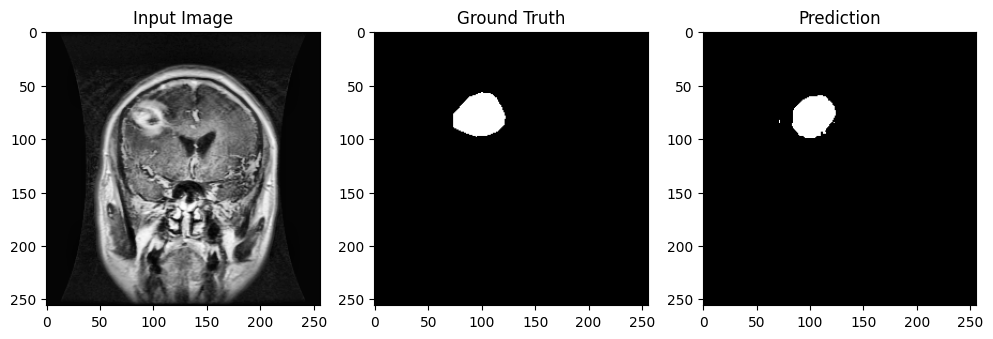

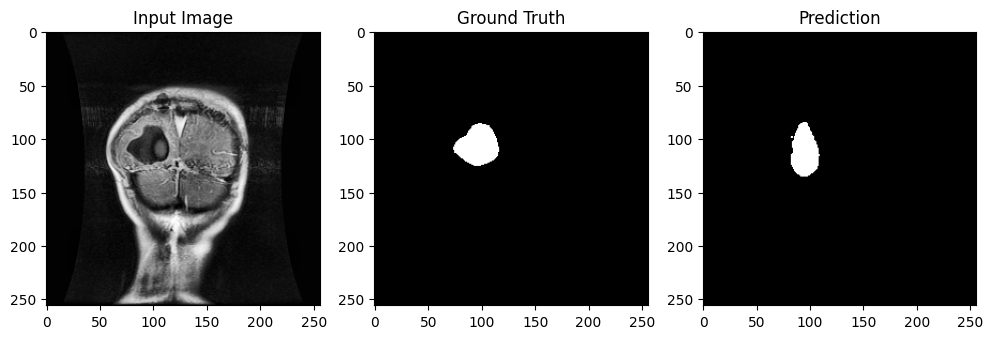

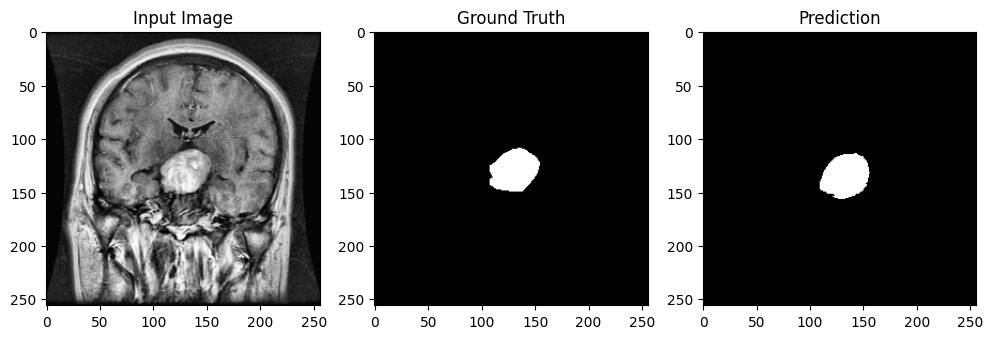

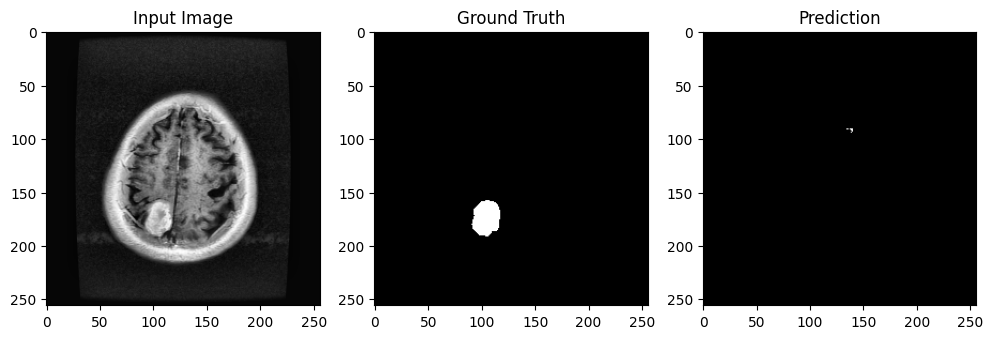

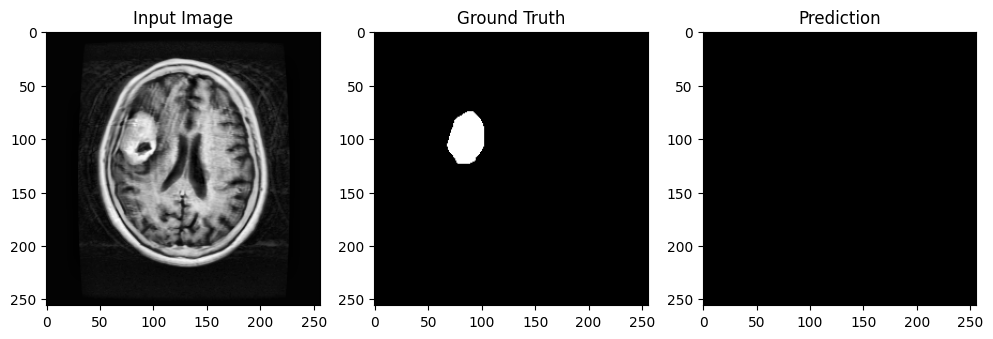

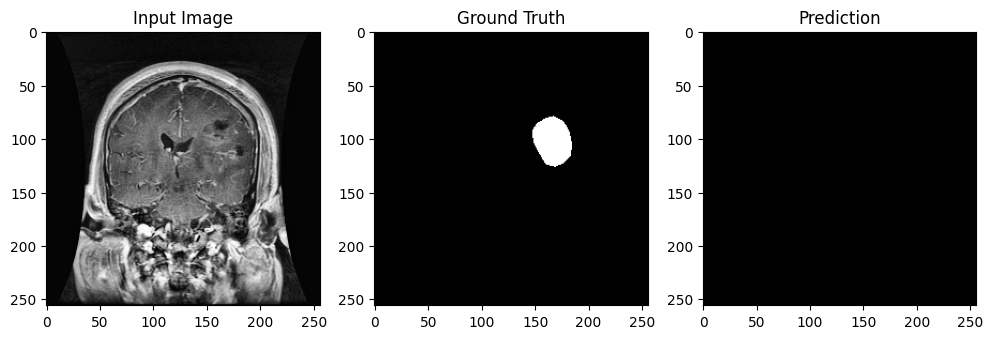

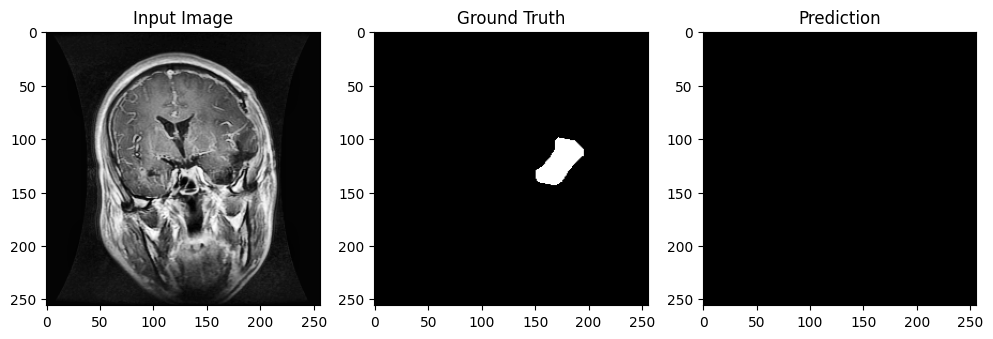

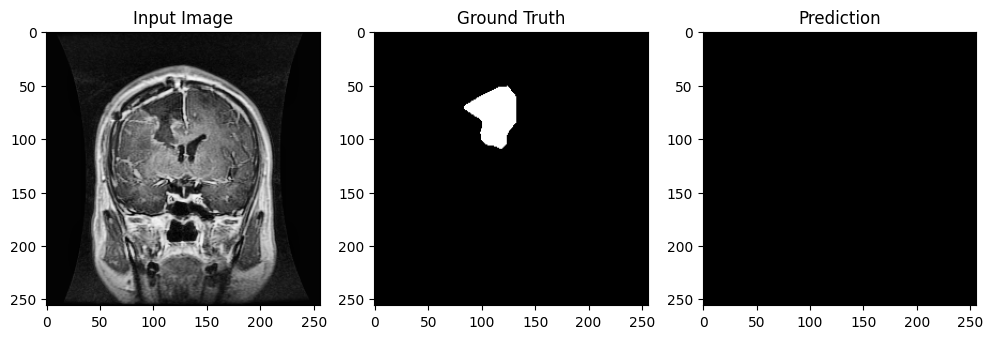

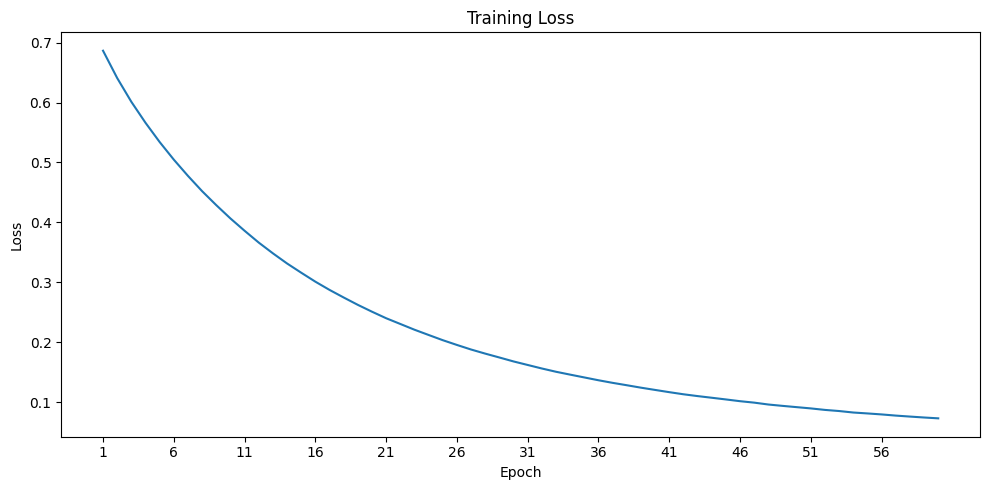

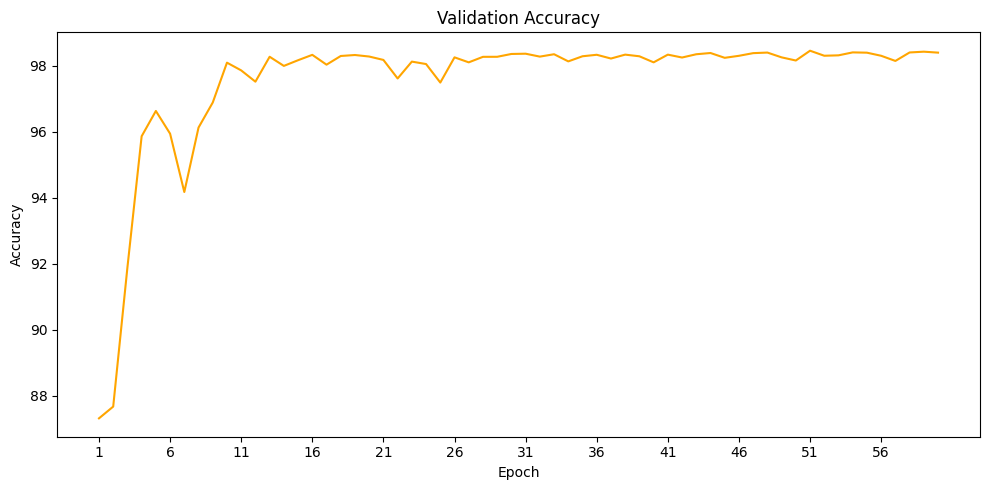

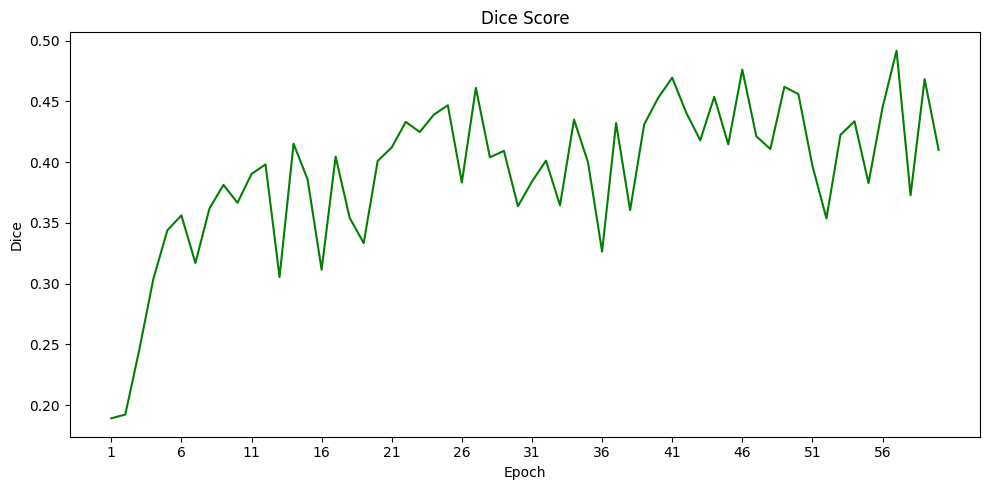

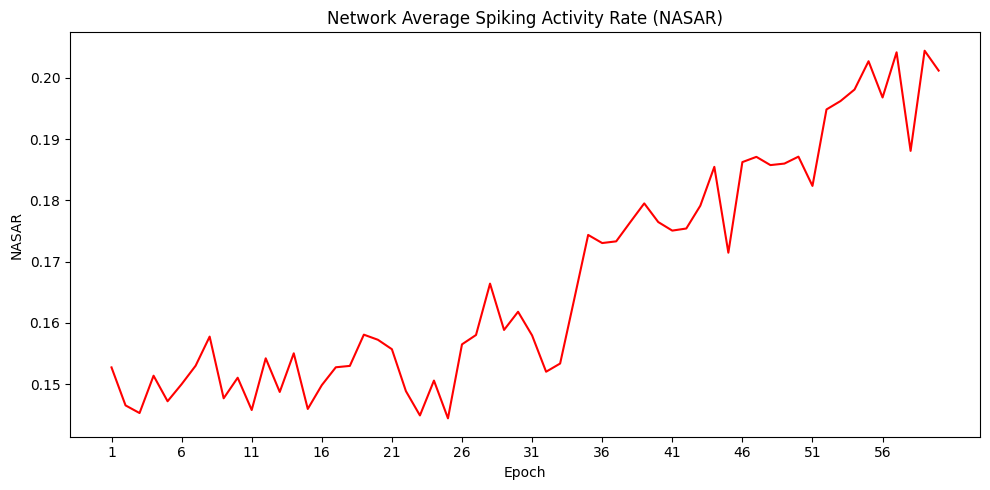

In [16]:
if __name__ == "__main__":
    main()

✅ Log loaded successfully.

🔍 Summary:
   🕒 Duration: 1921.22 seconds
   ⚡ Power Consumed: 0.0496 kWh
   🌱 CO₂ Emissions: 0.0233 kg
✅ Power consumption plot saved as 'attentionSNN_power_consumption_plot.png'.


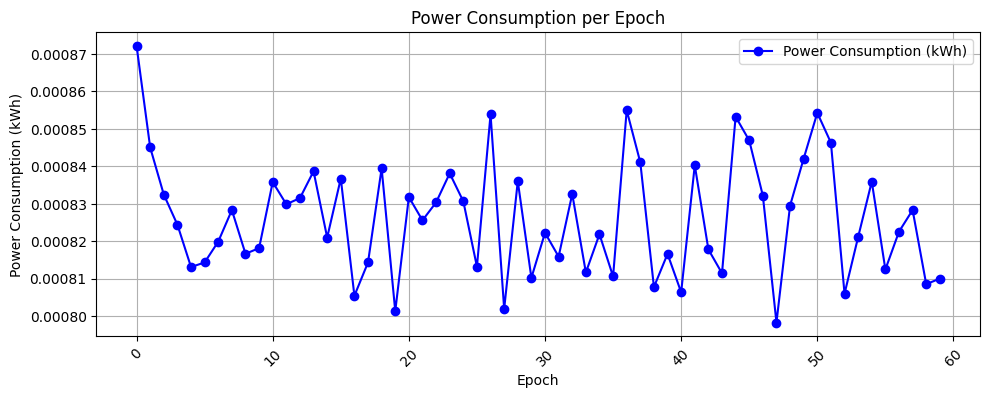

✅ CO₂ emission plot saved as 'attentionSNN_co2_emission_plot.png'.


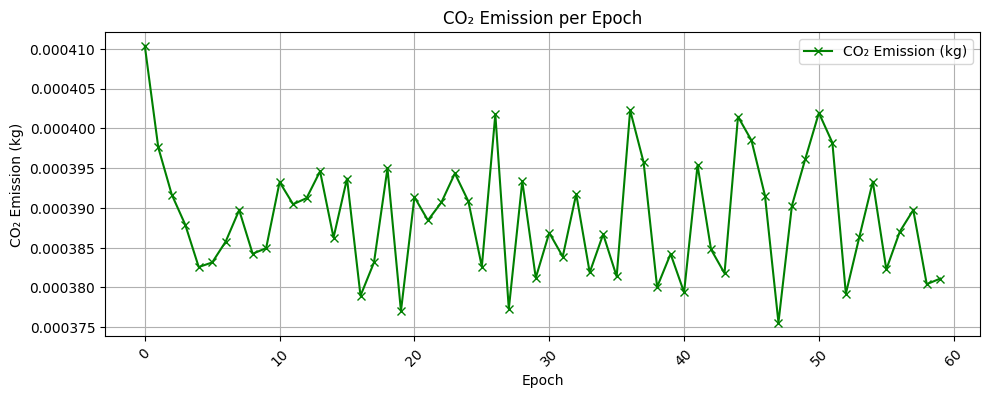

In [17]:
summarize_eco2ai_log("attentionSNN_eco2ai_logs.csv")